### Job-Shop Scheduling Problem

We are given:

- A finite set of jobs $J = \{1, \dots, N\}$
- A finite set of machines $M = \{1, \dots, K\}$

Each job $i \in J$ consists of a sequence of $K$ operations:\
$$
O_{i1},\ O_{i2},\ \dots,\ O_{iK}
$$

Each operation $O_{ij}$ must be processed on a specific machine  
$m = M_{ij}$ for a known processing time $p_{ij} > 0$.

---

#### Decision Variables

$$
x_{ij} = \text{start time of operation } O_{ij}
$$

$$
y_{ij} = \text{interval variable representing the duration of } O_{ij}
$$

with

$$
\text{size}(y_{ij}) = p_{ij}
$$

---

#### Constraints

1. **Technological order constraint:**  
   Each operation must start after the previous one of the same job finishes:  
   $$
   \text{endBeforeStart}(y_{i,j-1}, y_{ij}), \quad \forall i \in J, \; j = 2, \dots, K
   $$
   or equivalently:
   $$
   x_{i,j} \ge x_{i,j-1} + p_{i,j-1}
   $$

2. **Machine capacity constraint:**  
   No two operations can overlap on the same machine:  
   $$
   \text{noOverlap}\left( \{ y_{ij} \mid M_{ij} = k \} \right), \quad \forall k \in M
   $$
   or equivalently:
   $$
   (x_{ij} + p_{ij} \le x_{i'j'}) \;\lor\; (x_{i'j'} + p_{i'j'} \le x_{ij}), \quad \forall (i,j),(i',j'): M_{ij}=M_{i'j'}
   $$

---

#### Objective Function

Minimize the **makespan** $C_{\max}$:  
$$
\min \; C_{\max}
$$
subject to  
$$
C_{\max} \ge x_{iK} + p_{iK}, \quad \forall i \in J
$$

That is:
$$
\boxed{
\begin{aligned}
\min \quad & \max_{i \in J} \text{endOf}(y_{iK}) \\
\text{s.t.} \quad
& \text{noOverlap}\left( \{ y_{ij} \mid M_{ij} = k \} \right), && \forall k \in M \\
& \text{endBeforeStart}(y_{i,j-1}, y_{ij}), && \forall i \in J, j = 2, \dots, K \\
& y_{ij} = \text{interval variable of size } p_{ij}, && \forall i,j
\end{aligned}
}
$$

---

#### Python Correspondence

| Mathematical term | CP Optimizer expression |
|--------------------|-------------------------|
| $y_{ij}$ | `interval_var(size=DURATION[j][m])` |
| endBeforeStart | `end_before_start()` |
| noOverlap | `no_overlap()` |
| minimize makespan | `minimize(max(end_of(...)))` |


In [1]:
from docplex.cp.model import *
import os

In [2]:
# Read the input data file.
# Available files are jobshop_ft06, jobshop_ft10 and jobshop_ft20
# First line contains the number of jobs, and the number of machines.
# The rest of the file consists of one line per job.
# Each line contains list of operations, each one given by 2 numbers: machine and duration
filename = './data/jobshop_ft06.data'  # relative to current working directory
with open(filename, 'r') as file:
    NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
    JOBS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]

In [3]:
JOBS

[[2, 1, 0, 3, 1, 6, 3, 7, 5, 3, 4, 6],
 [1, 8, 2, 5, 4, 10, 5, 10, 0, 10, 3, 4],
 [2, 5, 3, 4, 5, 8, 0, 9, 1, 1, 4, 7],
 [1, 5, 0, 5, 2, 5, 3, 3, 4, 8, 5, 9],
 [2, 9, 1, 3, 4, 5, 5, 4, 0, 3, 3, 1],
 [1, 3, 3, 3, 5, 9, 0, 10, 4, 4, 2, 1]]

In [4]:
# Build list of machines. MACHINES[j][s] = id of the machine for the operation s of the job j
MACHINES = [[JOBS[j][2 * s] for s in range(NB_MACHINES)] for j in range(NB_JOBS)]

MACHINES

[[2, 0, 1, 3, 5, 4],
 [1, 2, 4, 5, 0, 3],
 [2, 3, 5, 0, 1, 4],
 [1, 0, 2, 3, 4, 5],
 [2, 1, 4, 5, 0, 3],
 [1, 3, 5, 0, 4, 2]]

In [5]:
# Build list of durations. DURATION[j][s] = duration of the operation s of the job j
DURATION = [[JOBS[j][2 * s + 1] for s in range(NB_MACHINES)] for j in range(NB_JOBS)]

DURATION

[[1, 3, 6, 7, 3, 6],
 [8, 5, 10, 10, 10, 4],
 [5, 4, 8, 9, 1, 7],
 [5, 5, 5, 3, 8, 9],
 [9, 3, 5, 4, 3, 1],
 [3, 3, 9, 10, 4, 1]]

In [6]:
# Create model
mdl = CpoModel()

# Create one interval variable per job operation
job_operations = [[interval_var(size=DURATION[j][m], name='O{}-{}'.format(j,m)) for m in range(NB_MACHINES)] for j in range(NB_JOBS)]

In [7]:
# Each operation must start after the end of the previous
for j in range(NB_JOBS):
    for s in range(1, NB_MACHINES):
        mdl.add(end_before_start(job_operations[j][s-1], job_operations[j][s]))

In [8]:
# Force no overlap for operations executed on a same machine
machine_operations = [[] for m in range(NB_MACHINES)]
for j in range(NB_JOBS):
    for s in range(NB_MACHINES):
        machine_operations[MACHINES[j][s]].append(job_operations[j][s])
for mops in machine_operations:
    mdl.add(no_overlap(mops))

In [9]:
# Minimize termination date
mdl.add(minimize(max(end_of(job_operations[i][NB_MACHINES-1]) for i in range(NB_JOBS))))

Solving model...
 ! --------------------------------------------------- CP Optimizer 22.1.2.0 --
 ! Minimization problem - 42 variables, 36 constraints
 ! TimeLimit            = 10
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 186.1 (before), 186.1 (after)
 !  . Memory usage      : 510.4 kB (before), 510.4 kB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         42                 -
 + New bound is 47
 ! Using iterative diving.
 *            65       73  0.03s        1      (gap is 27.69%)
 *            64      145  0.03s        1      (gap is 26.56%)
 *            62      217  0.03s        1      (gap is 24.19%)
 *            61      289  0.03s        1      (gap is 22.95%)
 *            60      361  0.03s        1      (gap is 21.67%)
 *            59      441  0

Solution:
-------------------------------------------------------------------------------
Model constraints: 36, variables: integer: 0, interval: 36, sequence: 6
Solve status: Optimal
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.02 sec
-------------------------------------------------------------------------------
Objective values: (55,), bounds: (55,), gaps: (0,)
Variables:
   O0-0 = IntervalVarValue(start=5, end=6, size=1)
   O0-1 = IntervalVarValue(start=6, end=9, size=3)
   O0-2 = IntervalVarValue(start=16, end=22, size=6)
   O0-3 = IntervalVarValue(start=30, end=37, size=7)
   O0-4 = IntervalVarValue(start=42, end=45, size=3)
   O0-5 = IntervalVarValue(start=49, end=55, size=6)
   O1-0 = IntervalVarValue(start=0, end=8, size=8)
   O1-1 = IntervalVarValue(start=8, end=13, size=5)
   O1-2 = IntervalVarValue(start=13, end=23, size=10)
   O1-3 = IntervalVarValue(start=28, end=38, size=10)
   O1-4 = IntervalVarValue(start=38, end=48, size=10)
   O1-

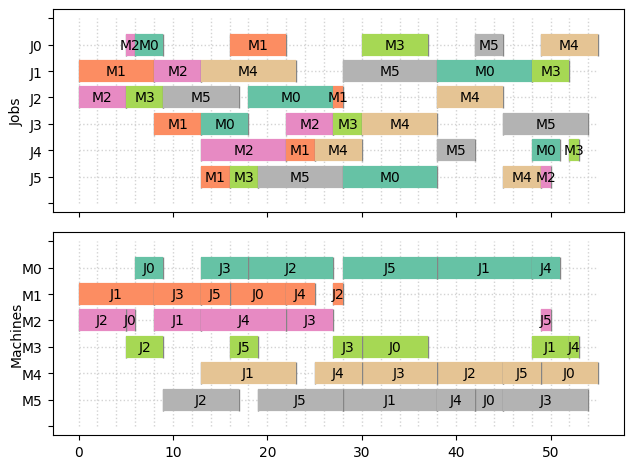

In [10]:
# Solve model
print('Solving model...')
res = mdl.solve(TimeLimit=10)
print('Solution:')
res.print_solution()

# Draw solution
import docplex.cp.utils_visu as visu
if res and visu.is_visu_enabled():
    visu.timeline('Solution for job-shop ' + filename)
    visu.panel('Jobs')
    for i in range(NB_JOBS):
        visu.sequence(name='J' + str(i),
                      intervals=[(res.get_var_solution(job_operations[i][j]), MACHINES[i][j], 'M' + str(MACHINES[i][j])) for j in
                                 range(NB_MACHINES)])
    visu.panel('Machines')
    for k in range(NB_MACHINES):
        visu.sequence(name='M' + str(k),
                      intervals=[(res.get_var_solution(machine_operations[k][i]), k, 'J' + str(i)) for i in range(NB_JOBS)])
    visu.show()